<h1 style="color:black;font-size:40px"><center>ACTIVIDAD 2</center></h1>

In [ ]:
# SOLO SI CORRIENDO EN COLAB
import sys
import os

# Instalamos Spark para Python
!pip install pyspark

# Instalamos Java SDK 8
!apt-get install -y openjdk-8-jdk -qq > /dev/null      
!echo $(/usr/libexec/java_home -v 1.8)

#set environment variable
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     
!echo 2 | update-alternatives --config java

# Bajar data
!git clone https://github.com/tvillani22/BD_UNLP.git 
sys.path.append('/content/BD_UNLP/')
os.chdir('BD_UNLP/')

>**Dado el dataset Genealogía el cual está formado por los datos  `<nombre_individuo, dni_individuo, dni_mamá>`, implemente un script que permita resolver las siguientes consultas.**

***Importo, creo los objetos, levanto la RDD y le doY formato a las filas. Luego creo un dataframe a partir de ella para usar esa API.***

In [3]:
from pyspark.sql import SQLContext, Row, SparkSession, functions as F

# Creo objetos
spark_session = SparkSession.builder\
                            .master("local")\
                            .appName('Activ2')\
                            .getOrCreate()
spark_context = spark_session._sc
sql_context = SQLContext(spark_context, spark_session)

# Creo RDD y armo schema
file_path = '../Data/Genealogia/Genealogia.txt'
gen = spark_context.textFile(file_path)
gen = gen.map(lambda t: t.split('\t'))\
         .map(lambda t: Row(nombre = t[0],
                            dni = int(t[1]),
                            dni_madre = None if t[2] == 'None' else int(t[2])))

# Creo la dataframe y exploro el schema
df = sql_context.createDataFrame(gen).persist()
df.printSchema()

root
 |-- nombre: string (nullable = true)
 |-- dni: long (nullable = true)
 |-- dni_madre: long (nullable = true)



***Hasta aquí, el DAG es...***
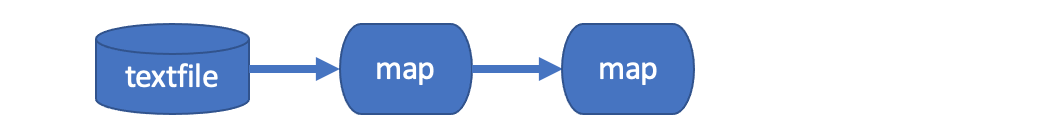
***Y la dataframe resultante es la que usan las funciones siguientes para resolver los incisos 1 y 2.***

***En el caso del inciso 3 el DAG es más complejo y se lo muestra al tratar ese punto.***

## Inciso 1
> **Dado los DNI de dos individuos determinar si son primos (dos individuos son primos si tienen la misma abuela).**

***Creo funciones que, dado un DNI, me permitan conocer (de ser posible) el DNI de la madre y de la abuela. En base a ello, una tercera función que me permita verificar si son primos, hermanos o ninguna de ambas.***

In [4]:
def dni_madre(df, dni):
    '''Devuelve el dni de la madre.

    PARÁMETROS:
    df: Pyspark Dataframe
    dni: int
    -----------
    RETORNA:
    out: int o None
      dni de la madre si ese dato está en el dataset. None, en caso contrario.
    '''
    res = df.filter(df.dni == dni).collect()
    if len(res) == 0:
        print(f'El DNI {dni} no está registrado en el dataset.', end=' ')
        return
    return res[0]['dni_madre']


def son_primos(df, i1, i2):
    '''Dados dos dni determina, si es posible, si son primos.

    PARÁMETROS:
    df: Pyspark Dataframe
    i1: int
    i2: int
    -----------
    RETORNA:
    out: bool o None
      bool si es posible determinarlo con el dataset. None, en caso contrario.
    '''
    dni_m1, dni_m2 = dni_madre(df, i1), dni_madre(df, i2)
    if dni_m1 is None and dni_m2 is None:
        print(f'Con la información disponible, no es posible conocer la relación entre {i1} y {i2}.')
        return 

    if None in [dni_m1, dni_m2]:
        dni =  dni_m1 if dni_m1 is not None else dni_m2
        if dni_madre(df, dni) is None:
            print(f'Y como el otro individuo no tiene abuela registrada, no es '
                  f'posible conocer la relación entre {i1} y {i2}.')
            return
        else: 
            print(f'Pero como el otro individuo tiene abuela registrada, los '
                  f'individuos {i1} y {i2} no son primos ni hermanos.')
            return False
  
    if dni_m1 == dni_m2:
        print(f'Los individuos {i1} y {i2} no son primos, pero son hermanos.')
        return False
  
    dni_a1, dni_a2 = dni_madre(df, dni_m1), dni_madre(df, dni_m2)
    if dni_a1 is None and dni_a2 is None:
        print(f'Con la información disponible, no es posible conocer la relación entre {i1} y {i2}.')
        return 
    if dni_a1 == dni_a2:
        print(f'Los individuos {i1} y {i2} son primos.')
        return True
    print(f'Los individuos {i1} y {i2} no son primos ni hermanos.')
    return False

***Evaluando varios pares de DNI como ejemplo de distintas posibilidades...***

In [5]:
i1, i2 = 4984, 635
son_primos(df, i1, i2)

i1, i2 = 4984, 634
son_primos(df, i1, i2)

i1, i2 = 4984, 632   
son_primos(df, i1, i2)

i1, i2 = 2014, 632   
son_primos(df, i1, i2);

Los individuos 4984 y 635 son primos.
Los individuos 4984 y 634 no son primos ni hermanos.
El DNI 632 no está registrado en el dataset. Pero como el otro individuo tiene abuela registrada, los individuos 4984 y 632 no son primos ni hermanos.
El DNI 632 no está registrado en el dataset. Y como el otro individuo no tiene abuela registrada, no es posible conocer la relación entre 2014 y 632.


***
## Inciso 2
>**Dado los DNI de dos individuos $i_1$ y $i_2$ determinar si $i_1$ es ancestro de $i_2$.**

***Construyo una función que vaya buscando y guardando los ancestros del individuo 2 hasta llegar a la línea más alta de la genealogía. Luego, evalúa si el individuo 1 está entre ellos.***

In [6]:
def es_ancestro(df, dni1 , dni2):
    '''Determina si un indivuo es ancestro de otro.

    PARÁMETROS:
    df : Pyspark Dataframe
    dni1 : int
    dni2 : int
    -----------
    RETORNA:
    out: bool
      True si el individuo de dni1 es ancestro del de dni2. False en caso contrario.
    '''
    ancestros = []
    dni = dni2
    while True:
        dni_m = dni_madre(df, dni)
        if dni_m is None:
            break
        else:
            ancestros.append(dni_m)
            dni = dni_m
    if dni1 in ancestros:
        print(f'El individuo de dni {dni1} es ancestro del de dni {dni2}.')
        return True
    else:
        print(f'El individuo de dni {dni1} no es ancestro del de dni {dni2}.')
        return False

***Evaluando distintos pares de DNI como ejemplo de distintas posibilidades...***

In [7]:
i1, i2 = 4032, 3746
es_ancestro(df, i1, i2)
i1, i2 = 432, 3746
es_ancestro(df, i1, i2);

El individuo de dni 4032 es ancestro del de dni 3746.
El individuo de dni 432 no es ancestro del de dni 3746.


***
## Inciso 3
>**Hallar el nombre de la “abuela” que tiene más descendientes.**

***Creo un dataframe que contenga solo las abuelas que están en la línea más alta de la genealogía, y  lo muestro.***

In [8]:
abu = df.filter(df.dni_madre.isNull())
abu.show()

+--------+----+---------+
|  nombre| dni|dni_madre|
+--------+----+---------+
|Gavgaial|4113|     null|
|Ymxunohg|1536|     null|
| Csmmtmc|1945|     null|
| Lwpodhj|4786|     null|
|Lvnpghoj| 979|     null|
| Dwnuphn| 310|     null|
|  Nmnfqa|1271|     null|
|  Cyumep|4295|     null|
|  Lpclex|2085|     null|
|Huoaczgp|1229|     null|
+--------+----+---------+



***Voy haciendo sucesivos `inner join` con el dataframe original para ir anexando los descendientes en las respectivas columnas. Lo hago hasta que el dataframe resultante esté vacío, lo cual implica que ya no había más descendientes para agregar a ninguna abuela, y me quedo con el dataframe previo, del que muestro la primera fila a modo de ilustrativo.***

In [9]:
# Creo una df con la que voy a ir haciendo los sucesivos joins, y la persisto
df_base = df.drop('nombre').persist()

# Defino variables iniciales del ciclo
dfj = abu.drop('dni_madre') # DF de super_abuelas sin esa columna
col_name_aux = 'dni'
i = 1
while True:
    col_name = 'dni_desc' + str(i)
    dfj_aux = df_base.withColumnRenamed('dni', col_name)
    dfj_aux = dfj.join(dfj_aux, dfj[col_name_aux] == dfj_aux['dni_madre'], 'inner').select(dfj['*'], dfj_aux[col_name]) 
    col_name_aux = col_name
    if dfj_aux.count() == 0:
        dfj.show(1)
        break
    else:
        dfj.unpersist()
        dfj = dfj_aux.persist()
        i += 1
df_base.unpersist();

+--------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+
|  nombre| dni|dni_desc1|dni_desc2|dni_desc3|dni_desc4|dni_desc5|dni_desc6|dni_desc7|dni_desc8|dni_desc9|dni_desc10|dni_desc11|dni_desc12|dni_desc13|
+--------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+
|Gavgaial|4113|     2014|     1607|      666|     1107|     4424|      721|     4576|     4887|      552|      2064|      3615|      4494|      1641|
+--------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+
only showing top 1 row



***Finalmente, agrupo por las abuelas que hayan quedado en este dataframe y cuento el número de descendientes, mostrando el resultado y quedándome con la que tiene la mayor cantidad.***

In [10]:
df_ = dfj.groupBy(dfj.nombre).agg(F.count('*').alias('num_descendientes'))
df_.show()

max_n_desc = df_.agg(F.max(df_['num_descendientes'])).first()[0]
nombre, num_desc = df_.filter(df_.num_descendientes == max_n_desc).first()
print(f'La abuela con más descendientes es {nombre}, con {num_desc}.')

+--------+-----------------+
|  nombre|num_descendientes|
+--------+-----------------+
| Lwpodhj|              106|
|Gavgaial|              243|
+--------+-----------------+

La abuela con más descendientes es Gavgaial, con 243.


***Por último, "despersisto" las persistidas y verifico que no quede nada persistido.***

In [11]:
dfj.unpersist()
df.unpersist()
print('Persistidas:', len(spark_context._jsc.getPersistentRDDs().items()))

0

***El DAG para este proceso resulta...***
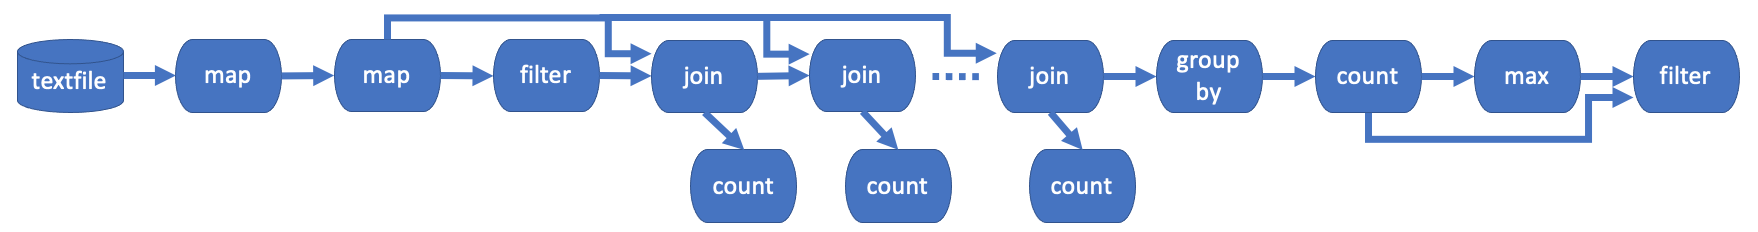
***
***